In [1]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from typing import List
#import h5py

### Data loading for new acquisition and preprocessing

In [2]:

def extract_struct_fields(struct, prefix=""):
    """
    Recursively extract fields from a MATLAB struct, including nested structs.

    Args:
    struct (dict): The MATLAB struct or sub-struct to extract.
    prefix (str): The prefix for the field names (used for nested fields).
    
    Returns:
    dict: A flat dictionary with keys as 'prefix_field' and values as the field data.
    """
    data = {}
    
    for field_name, field_value in struct.items():
        # Create a new key name for this field
        new_key = f"{prefix}_{field_name}" if prefix else field_name

        if isinstance(field_value, dict):
            # If the field is a struct (dict), recursively extract its fields
            nested_data = extract_struct_fields(field_value, new_key)
            data.update(nested_data)
        else:
            # Otherwise, it's a regular field, so add it to the data dictionary
            data[new_key] = field_value
    
    return data

def search_for_neural_data(field_data):
    """
    Recursively search for 'rawf_f_f_n' and fields containing 'dff' in the nested structure.
    
    Args:
    field_data (dict): A dictionary-like structure representing a MATLAB struct.
    
    Returns:
    tuple: Two dictionaries, one for 'rawf_f_f_n' data and one for 'dff' data, or None if not found.
    """
    rawf_data = None
    dff_data = {}
    
    # Base case: If rawf_f_f_n is in the current struct
    if 'rawf_f_f_n' in field_data:
        rawf_data = field_data['rawf_f_f_n']
    
    # Search for fields containing 'dff'
    for key, value in field_data.items():
        if isinstance(value, np.ndarray) and 'dff' in key.lower():
            dff_data[key] = value
    
    # If we found both rawf and dff data, return them
    if rawf_data is not None or dff_data:
        return rawf_data, dff_data
    
    # Recursively search in nested structs
    for key, value in field_data.items():
        if isinstance(value, dict):
            result = search_for_neural_data(value)
            if result is not None:
                return result
    
    return None

def process_resp_to_neural_df(ts_resp):
    """
    Process the ts.resp structure to extract raw fluorescence data (rawf_f_f_n) from nested structs.
    
    Args:
    ts_resp (dict): The ts.resp structure as a nested dictionary.
    
    Returns:
    pd.DataFrame: A DataFrame containing the extracted neural data with appropriate column names.
    """
    neural_data = {}
    
    # Loop through the first-level fields in ts_resp (e.g., 'mbon09')
    for field_name, field_data in ts_resp.items():
        # Search for the 'rawf_f_f_n' field in nested structs
        result = search_for_neural_data(field_data)
        
        # If data is found, process it
        if result is not None:
            raw_f_data, dff_data = result
            
            # Process rawf_f_f_n data
            if raw_f_data is not None:
                if raw_f_data.ndim == 1:
                    # If raw_f_data is 1-dimensional
                    neural_data[f"{field_name}_rawf1"] = raw_f_data
                else:
                    for i in range(raw_f_data.shape[0]):
                        column_name = f"{field_name}_rawf{i+1}"
                        neural_data[column_name] = raw_f_data[i, :]
            
            # Process dff data
            for dff_key, dff_value in dff_data.items():
                if dff_value.ndim == 1:
                    neural_data[f"{field_name}_dff1"] = dff_value
                else:
                    for i in range(dff_value.shape[0]):
                        column_name = f"{field_name}_dff{i+1}"
                        neural_data[column_name] = dff_value[i, :]
    
    # Convert the dictionary to a pandas DataFrame
    neural_df = pd.DataFrame(neural_data)
    
    return neural_df


def load_matfile_to_df(matfile_path):
    """
    Load a MATLAB v7.3 .mat file using the mat73 library and extract struct variables into a pandas DataFrame.
    
    Args:
    matfile_path (str): Path to the .mat file.
    
    Returns:
    pd.DataFrame: A DataFrame with extracted fields from the MATLAB struct.
    """
    # Load the .mat file
    mat_data = mat73.loadmat(matfile_path)

    # Extract the 'ts' struct from the loaded data
    ts = mat_data['ts']
    
    # Dictionary to store all extracted data
    data = {}

    # List of relevant sub-structs, including 'resp'
    sub_structs = ['flypos', 'ball', 'vis', 'resp']
    
    # Loop over each sub-struct and extract its fields
    for sub_struct_name in sub_structs:
        if sub_struct_name in ts:
            sub_struct = ts[sub_struct_name]
            #print(sub_struct)
            # Special case for 'resp' sub-struct
            if sub_struct_name == 'resp':
                neural_df = process_resp_to_neural_df(sub_struct)
                #print(neural_df)
                # Add the neural data columns to the main data dictionary
                #for col in neural_df.columns:
                    #data[col] = neural_df[col]
            else:
                # Use the recursive function to extract all other fields
                sub_struct_data = extract_struct_fields(sub_struct, sub_struct_name)
                # Update the main data dictionary
                data.update(sub_struct_data)

    # Convert the dictionary into a pandas DataFrame
    behav_df = pd.DataFrame(data)
    # Add 'ti' (time) to both df and neural_df
    if 'ti' in ts:
        time = ts['ti']
        behav_df['time'] = time  # Add time to df
        neural_df['time'] = time  # Add time to neural_df as well
    
    return behav_df, neural_df



# Example usage:
behav_df, neural_df = load_matfile_to_df('//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/20241008-3_MBON09_no_jump/ts_trial1.mat')
# print(df.head())


In [4]:
def rename_dataframe(df):
    # Drop columns containing 'int'
    df = df.drop(columns=[col for col in df.columns if 'int' in col])

    # Rename specified columns
    rename_dict = {
        'ball_forvel': 'fwV',
        'ball_sidevel': 'sideV',
        'ball_yawvel': 'yawV',
        'vis_yaw': 'heading',
        'ball_yaw': 'heading_unjumped',
        'vis_yawvel': 'heading_diff'
    }
    df = df.rename(columns=rename_dict)
    # Modify the column 'column_name' in place by dividing by 0.7
    #df['yawV'] = df['yawV'] / 0.8
    #df['heading'] = df['heading'] + np.pi
    #df['heading_unjumped'] = df['heading_unjumped'] + np.pi
    return df

behav_df = rename_dataframe(behav_df)
behav_df

,flypos_x,flypos_y,fwV,sideV,heading_unjumped,yawV,heading,heading_diff,time
0,0.000000,0.000000,13.988239,-2.937209,1.049387,-1.736320,-2.758996,1.392537,0.000000
1,-0.383052,0.830508,5.905571,-4.311122,0.805481,-2.138748,-2.560562,1.748915,0.125085
2,-0.557175,1.432750,3.606335,-3.230617,0.497789,-1.232457,-2.309947,1.009971,0.254565
3,-0.427364,1.991824,4.420899,-1.034944,0.486964,0.026749,-2.300889,-0.022372,0.380973
4,-0.333712,2.321051,2.641152,-0.443081,0.504598,-0.022440,-2.315642,0.012395,0.508785
...,...,...,...,...,...,...,...,...,...
3296,81.725006,-41.593193,1.104807,0.989070,2.968503,0.951748,-0.257115,-0.724376,419.467468
3297,81.933472,-41.718643,1.818827,-0.606884,3.073903,0.718184,-0.324429,-0.359346,419.594360
3298,82.150017,-41.816883,1.701602,-0.747005,-3.131617,-0.143667,-0.348629,0.099767,419.722321
3299,82.122459,-42.008564,1.042234,1.126929,3.037165,0.391266,-0.299018,-0.282126,419.848480


In [6]:
def add_open_loop_column(df,shift=0):
    # Calculate the number of seconds within the current minute
    seconds_in_minute = (df['time']+shift) % 60
    
    # Create the 'is_open_loop' column
    df['is_open_loop'] = np.where((seconds_in_minute >= 50) & (seconds_in_minute < 60), 1, 0)
    
    return df

#behav_df = add_open_loop_column(behav_df,-34.5)
#behav_df

In [7]:
def detect_jumps_unwrapped(df, heading_column, time_column, jump_threshold=np.pi/4, min_time_between_jumps=30):
    # Unwrap the heading data
    unwrapped_heading = np.unwrap(df[heading_column])
    
    # Calculate the difference between consecutive unwrapped headings
    heading_diff = np.diff(unwrapped_heading)
    
    # Find potential jump indices
    potential_jump_indices = np.where(np.abs(heading_diff) > jump_threshold)[0]
    
    # Initialize list to store confirmed jump indices
    jump_indices = []
    
    # Check each potential jump
    for i, jump_index in enumerate(potential_jump_indices):
        if i == 0:
            jump_indices.append(jump_index)
        else:
            # Check if enough time has passed since the last jump
            time_since_last_jump = df[time_column].iloc[jump_index] - df[time_column].iloc[jump_indices[-1]]
            if time_since_last_jump >= min_time_between_jumps:
                jump_indices.append(jump_index)
    
    return jump_indices


jump_indices = detect_jumps_unwrapped(behav_df, heading_column='heading', time_column='time')

jump_indices

[]

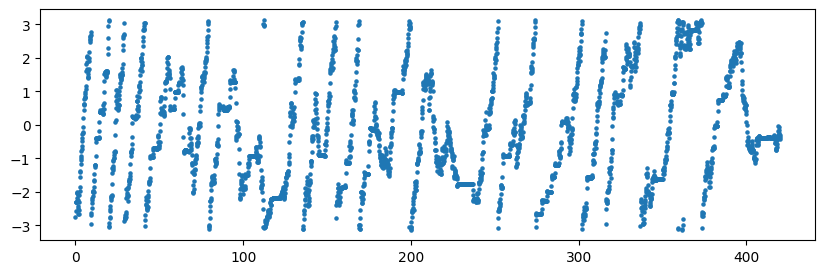

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(behav_df['time'], behav_df['heading'],s=5)
#ax.scatter(behav_df['time'], behav_df['heading'],s=5,alpha=0.5,c = behav_df['is_open_loop'])
#ax.plot(behav_df['time'], behav_df['is_open_loop'])
#[ax.axvline(_x, ymin=-np.pi, ymax=np.pi, color='red', linestyle='--') for _x in np.array(behav_df['time'].iloc[jump_indices])];

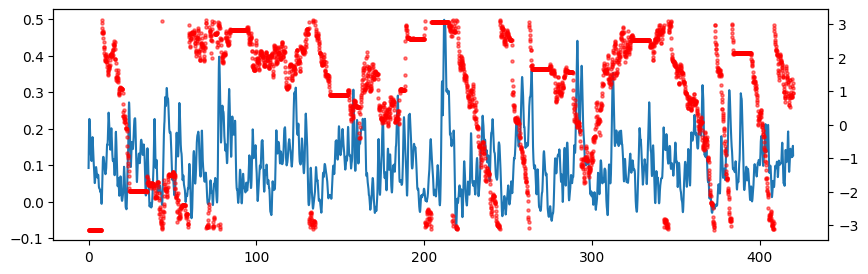

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(neural_df['time'], neural_df['mbon09_dff2'])
ax2 = ax.twinx()
#ax2.plot(behav_df['time'], behav_df['yawV'], color='r',alpha=0.5)
ax2.scatter(behav_df['time'], behav_df['heading'],s=5,alpha=0.5,color='r')
#ax.plot(neural_df['time'], neural_df['mbon09_rawf2_dff'])
#[ax.axvline(_x, ymin=-np.pi, ymax=np.pi, color='red', linestyle='--') for _x in np.array(behav_df['time'].iloc[jump_indices])];

In [124]:
def tuning_heatmap_2d(behavior_var1, behavior_var2, filtered_columns, neural_activity, neuron_to_plot, num_bins, ax=None):
    """
    Plot a 2D tuning heatmap on the given matplotlib Axes.

    Parameters:
    - behavior_var1: array-like, the first behavioral variable to bin (x-axis).
    - behavior_var2: array-like, the second behavioral variable to bin (y-axis).
    - filtered_columns: list of str, names of the neurons.
    - neural_activity: 2D array-like, neural activity data with shape (neurons, observations).
    - neuron_to_plot: int, index of the neuron to plot.
    - num_bins: int, number of bins to divide each behavior variable into.
    - ax: matplotlib.axes.Axes, the axes object to plot on. If None, a new figure is created.

    Returns:
    - fig: matplotlib.figure.Figure, the figure object containing the plot.
    - ax: matplotlib.axes.Axes, the axes object containing the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure

    # Bin the behavioral variables
    bins1 = np.linspace(np.min(behavior_var1), np.max(behavior_var1), num_bins+1)
    bins2 = np.linspace(np.min(behavior_var2), np.max(behavior_var2), num_bins+1)
    
    # Create a 2D array to store binned activity
    binned_activity = np.zeros((num_bins, num_bins))
    
    # Bin the data and calculate mean activity
    for i in range(num_bins):
        for j in range(num_bins):
            indices = np.where(
                (behavior_var1 >= bins1[i]) & (behavior_var1 < bins1[i+1]) &
                (behavior_var2 >= bins2[j]) & (behavior_var2 < bins2[j+1])
            )[0]
            binned_activity[j, i] = np.mean(neural_activity[neuron_to_plot, indices])
    
    # Create the heatmap
    im = ax.imshow(binned_activity, origin='lower', aspect='auto', cmap='viridis')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    #cbar.set_label(f'Mean activity of {filtered_columns[neuron_to_plot]}')
    
    # Set labels and title
    ax.set_xlabel(behavior_var1.name)
    ax.set_ylabel(behavior_var2.name)
    #ax.set_title(f'2D Tuning Heatmap for {filtered_columns[neuron_to_plot]}')
    
    # Set tick labels
    ax.set_xticks(np.linspace(0, num_bins-1, 5))
    ax.set_yticks(np.linspace(0, num_bins-1, 5))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(np.min(behavior_var1), np.max(behavior_var1), 5)])
    ax.set_yticklabels([f'{y:.2f}' for y in np.linspace(np.min(behavior_var2), np.max(behavior_var2), 5)])
    
    return fig, ax

c:\Users\wilson\anaconda3\envs\2p_process\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\wilson\anaconda3\envs\2p_process\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


(<Figure size 1000x800 with 2 Axes>, <Axes: xlabel='heading', ylabel='fwV'>)

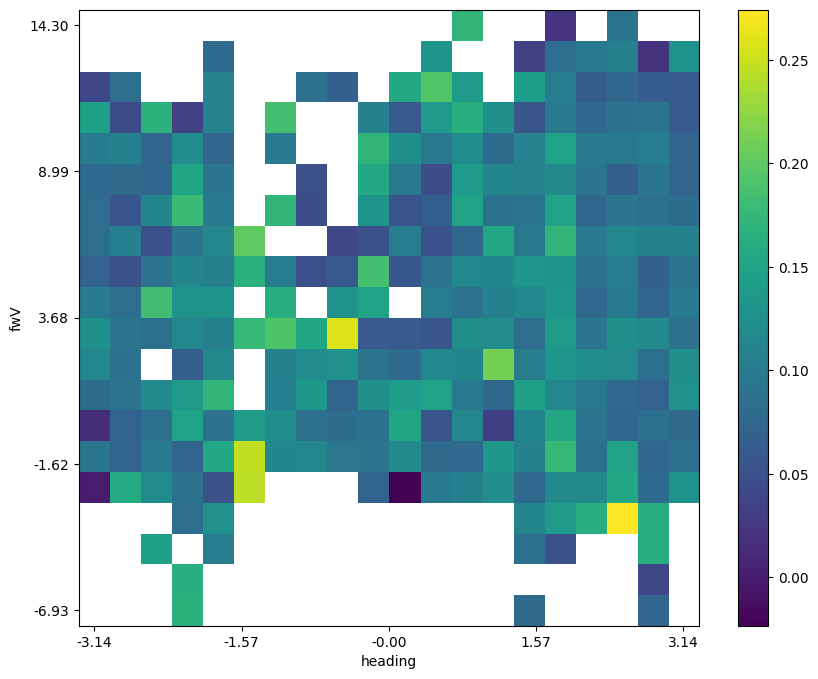

In [125]:
#filtered_behavior_variables = [filter_based_on_histogram(var, 0.5) for var in behavioral_variables]
filtered_columns = ['mbon09_dff2']
neural_activity = neural_df[filtered_columns]
neurons_to_plot = range(neural_activity.shape[1])
#neural_activity.shape[1]
tuning_heatmap_2d(behav_df.heading, behav_df.fwV, filtered_columns, np.array(neural_activity.T), neurons_to_plot, 20, ax=None)

In [126]:

def scale_circular_variable(series, scale_factor=1/0.8):
    """
    Scale the delta of a circular variable in a pandas Series.
    
    Args:
    series (pd.Series): Input time series with circular variable between -pi to pi
    scale_factor (float): Factor to scale the delta (default: 0.7)
    
    Returns:
    pd.Series: Scaled circular variable, still between -pi to pi
    """
    # Calculate the differences between consecutive points
    deltas = series.diff()
    
    # Handle the circular nature of the data
    deltas = (deltas + np.pi) % (2 * np.pi) - np.pi
    
    # Scale the deltas
    scaled_deltas = deltas * scale_factor
    
    # Cumulative sum of scaled deltas
    cumsum = scaled_deltas.cumsum()
    
    # Ensure the result stays within -pi to pi
    result = (cumsum + np.pi) % (2 * np.pi) - np.pi
    
    # Set the first value to match the original series
    result.iloc[0] = series.iloc[0]
    
    return result

In [127]:
def reconstruct_path(df, ball_d = 9):
    #circum = ball_d * np.pi #circumference of ball, in mm
    mmPerRad = ball_d / 2 # mm per rad of ball
    fwdAngVel = df.fwV/mmPerRad
    sideAngVel = df.sideV/mmPerRad 
    # zero heading
    #scaled_hd = scale_circular_variable(df.heading)
    zeroedH = (df.heading - df.heading[0])
    time_bin = np.diff(df.time)
    # movement in x (in degrees) at each time point
    xChangePos = (fwdAngVel[0:-1]*time_bin)*np.sin(zeroedH[0:-1]) + (sideAngVel[0:-1]*time_bin)*np.sin(zeroedH[0:-1]+np.pi/4)
    xPos = (np.cumsum(xChangePos) - xChangePos[0])*mmPerRad
    yChangePos = (fwdAngVel[0:-1]*time_bin)*np.cos(zeroedH[0:-1]) + (sideAngVel[0:-1]*time_bin)*np.cos(zeroedH[0:-1]+np.pi/4)
    yPos = (np.cumsum(yChangePos) - yChangePos[0])*mmPerRad
    xPos_padded = pd.concat([xPos, pd.Series(xPos.iloc[-1])], ignore_index=True) 
    yPos_padded = pd.concat([yPos, pd.Series(yPos.iloc[-1])], ignore_index=True) 
    df['xPos'] = xPos_padded
    df['yPos'] = yPos_padded
    return xPos_padded, yPos_padded

In [128]:
xPos, yPos = reconstruct_path(behav_df, ball_d = 9)

In [129]:
len(behav_df)

3555

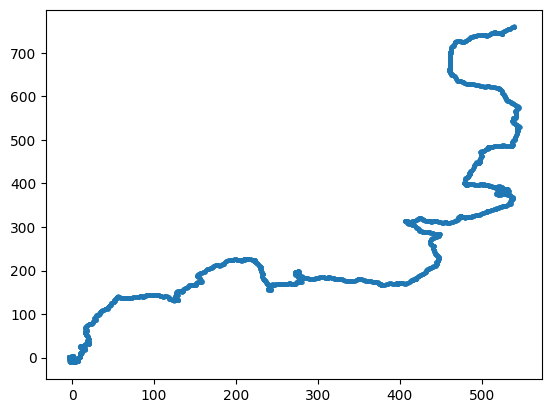

In [130]:
plt.scatter(behav_df['flypos_x'], behav_df['flypos_y'],s=5)
#plt.scatter(xPos, yPos, s=5,color='red')

In [3]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
example_path_data = base_path+"20241008-3_MBON09_no_jump/data/"
example_path_results = base_path+"20241008-3_MBON09_no_jump/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, trial_num)


In [4]:
neural_df_new

,mbon21_rawf1,mbon21_dff1,time
0,90.830376,-0.013077,0.000000
1,91.355957,-0.007366,0.125085
2,94.539192,0.027221,0.254565
3,97.969215,0.064490,0.380973
4,100.111961,0.087773,0.508785
...,...,...,...
3296,112.465584,0.222002,419.467468
3297,111.586571,0.212451,419.594360
3298,110.264793,0.198089,419.722321
3299,109.809868,0.193146,419.848480


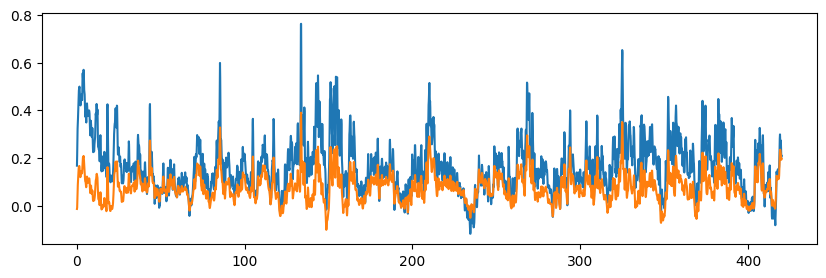

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(neural_df.time, neural_df.MBON09L)
ax.plot(neural_df.time, neural_df_new.mbon21_dff1)

### Old analysis

In [8]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/MBON09/"
example_path_data = base_path+"20220525-3_MBON09_GCAMP7f/data/"
example_path_results = base_path+"20220525-3_MBON09_GCAMP7f/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.


In [9]:
behav_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,xPos,yPos
0,0.000000,0.000000,0.000000,0.000000,5.198990,0.000000,0.000000,0.000000,0,5.198990,0.000000,0.000000
1,0.240513,4.010723,-1.954034,5.940137,5.331701,1.954034,5.940137,11.904894,1,5.331701,0.098317,0.933732
2,0.481026,1.991145,10.656325,7.828723,5.636222,10.656325,7.828723,20.476193,1,5.636222,0.490316,1.436254
3,0.721539,4.764032,-0.692989,3.299474,6.055103,0.692989,3.299474,8.756496,1,6.055103,1.342691,2.188119
4,0.962052,4.591877,2.849881,7.101535,0.040090,2.849881,7.101535,14.543293,1,6.323275,2.389592,2.647129
...,...,...,...,...,...,...,...,...,...,...,...,...
1742,418.973587,2.241620,-5.264650,-11.785632,0.729636,5.264650,11.785632,19.291901,1,7.012821,2206.385425,528.283700
1743,419.214100,2.729490,5.037798,14.404383,0.583755,5.037798,14.404383,22.171670,1,6.866941,2207.099253,528.146520
1744,419.454613,7.820932,6.001101,-7.586403,0.928542,6.001101,7.586403,21.408436,1,7.211728,2208.837738,527.235272
1745,419.695126,8.819422,-4.091549,1.240521,0.935191,4.091549,1.240521,14.151492,1,7.218376,2210.723511,526.388271


In [6]:
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df,window_size=30)
#behav_df = imaging_behavior_functions.segment_path(behav_df,rho_threshold=0.3,min_duration_below_rho=15)

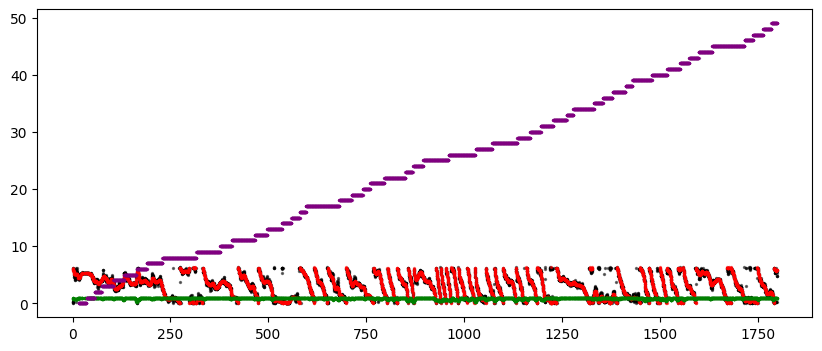

In [120]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(behav_df['time'], behav_df['heading'],s=2,color='black',alpha=0.5,label='heading')
ax.scatter(behav_df['time'], behav_df['theta_g'],s=2,color='red',alpha=0.5,label='goal')
ax.scatter(behav_df['time'], behav_df['rho_t'],s=2,color='green',alpha=0.5,label='straightness')
ax.scatter(behav_df['time'], behav_df['segment'],s=2,color='purple',alpha=0.5,label='segment')


In [21]:
neural_df

,time,MBON09L,MBON09R
0,0.000000,0.578032,0.385139
1,0.240513,0.800811,0.458976
2,0.481026,1.092861,0.624555
3,0.721539,1.361873,0.834887
4,0.962052,1.545436,0.961813
...,...,...,...
1742,418.973587,0.036120,0.195531
1743,419.214100,0.044323,0.295756
1744,419.454613,0.017102,0.241836
1745,419.695126,0.031039,0.155923


#### Explore circulr clustering and segment splitting 

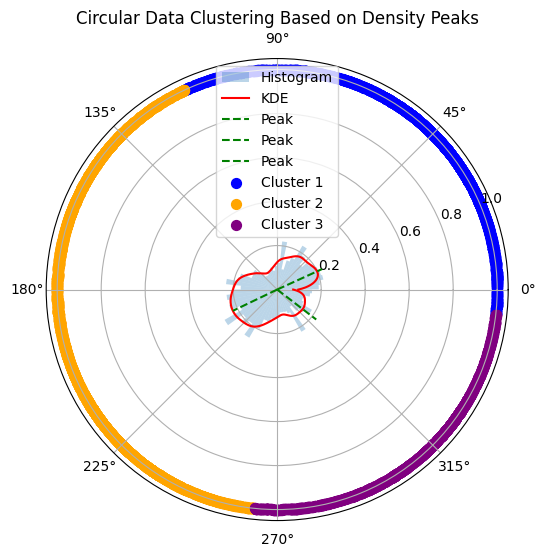

In [51]:
def circular_kde(theta, bandwidth=0.1):
    """
    Perform Kernel Density Estimation (KDE) on circular data.
    
    Parameters:
    - theta: array of angular data (in radians).
    - bandwidth: bandwidth for the KDE kernel (default is 0.1).
    
    Returns:
    - kde_values: KDE estimated values.
    - theta_grid: Corresponding angles (in radians).
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)
    kde = gaussian_kde(theta, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

def find_density_peaks(kde_values, theta_grid, threshold=0.5):
    """
    Find peaks in the KDE distribution to identify clusters.
    
    Parameters:
    - kde_values: KDE values from the circular KDE.
    - theta_grid: Corresponding angular values (in radians).
    - threshold: Minimum KDE value to consider as a peak.
    
    Returns:
    - peak_angles: Angles (in radians) of the detected density peaks.
    """
    peaks = np.where((kde_values[1:-1] > kde_values[:-2]) & (kde_values[1:-1] > kde_values[2:]))[0] + 1
    peak_angles = theta_grid[peaks][kde_values[peaks] > threshold]
    return peak_angles

def assign_clusters(theta, peak_angles):
    """
    Assign data points to clusters based on proximity to density peaks.
    
    Parameters:
    - theta: array of angular data (in radians).
    - peak_angles: Angles (in radians) of the density peaks.
    
    Returns:
    - cluster_labels: Array of cluster labels assigned to each data point.
    - cluster_peak_angles: Array of peak angles corresponding to each data point's assigned cluster.
    """
    # Compute distances to each peak angle
    distances = [np.abs(np.angle(np.exp(1j * (theta - peak)))) for peak in peak_angles]
    
    # Assign each point to the closest peak (minimum distance)
    cluster_labels = np.argmin(distances, axis=0)
    cluster_peak_angles = peak_angles[cluster_labels]
    
    return cluster_labels, cluster_peak_angles


# Circular KDE
kde_values, theta_grid = circular_kde(behav_df['heading'])

# Find peaks in the density distribution
peak_angles = find_density_peaks(kde_values, theta_grid, threshold=0.05)

# Assign clusters and get peak angle for each entry
cluster_labels, cluster_peak_angles = assign_clusters(behav_df['heading'].values, peak_angles)

# Add the cluster label and the corresponding cluster peak angle back to the DataFrame
behav_df['cluster_label'] = cluster_labels
behav_df['cluster_peak_angle'] = cluster_peak_angles

# Plot the clustering results for visualization
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
ax.hist(behav_df['heading'], bins=60, density=True, alpha=0.3, label="Histogram")
ax.plot(theta_grid, kde_values, label="KDE", color="red")

# Mark the peaks
for peak in peak_angles:
    ax.plot([peak, peak], [0, max(kde_values)], color='green', linestyle="--", label="Peak")

# Assign colors to the clusters and plotting
colors = ['blue', 'orange', 'purple']
for cluster in np.unique(behav_df['cluster_label']):
    cluster_data = behav_df[behav_df['cluster_label'] == cluster]['heading']
    ax.scatter(cluster_data, np.ones_like(cluster_data), label=f'Cluster {cluster+1}', s=50, color=colors[cluster])

ax.set_title("Circular Data Clustering Based on Density Peaks")
ax.legend()
plt.show()


In [73]:
behav_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,speed,theta_g,rho_t,segment,cluster_label,cluster_peak_angle
0,0.000000,0.000000,0.000000,0.000000,5.914728,0.000000,0.000000,0.000000,0,5.914728,-0.187872,0.000000,0.000000,0.000000,NaN,NaN,NaN,2,5.628425
1,0.240513,2.775515,-23.169322,9.898590,0.136545,23.169322,9.898590,35.843427,1,6.419731,-0.003999,-0.097606,0.463102,25.347644,4.495727,0.706590,NaN,0,0.428113
2,0.481026,5.205855,0.094563,0.038503,0.280519,0.094563,0.038503,5.338921,1,6.563704,-0.004336,0.660881,1.460878,5.206856,4.492939,0.704010,NaN,0,0.428113
3,0.721539,-0.205428,-8.157266,2.878003,0.210470,8.157266,2.878003,11.240698,1,6.493655,-0.009791,0.483032,1.387931,8.652520,4.490187,0.701387,NaN,0,0.428113
4,0.962052,1.874244,3.946489,2.158772,0.424362,3.946489,2.158772,7.979505,1,6.707547,-0.015156,0.878685,1.703753,4.873178,4.487339,0.698902,NaN,0,0.428113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,1799.036986,1.926358,2.960902,-0.921364,5.654786,2.960902,0.921364,5.808624,1,-214.256700,-0.235759,-267.112870,-190.773560,3.650576,1.252671,0.266896,NaN,2,5.628425
7481,1799.277499,3.481335,15.677841,-12.146880,5.314793,15.677841,12.146880,31.306056,1,-214.596693,-0.248296,-267.530992,-189.791397,20.136065,1.253476,0.269682,NaN,2,5.628425
7482,1799.518012,3.405842,6.682099,-3.682772,4.822469,6.682099,3.682772,13.770714,1,-215.089017,-0.036270,-268.296255,-189.293867,8.355419,1.253698,0.272490,NaN,2,5.628425
7483,1799.758525,0.903440,-1.801781,-0.765262,4.835489,1.801781,0.765262,3.470482,1,-215.075997,-0.034941,-268.477959,-189.223884,2.155978,1.252759,0.275297,NaN,2,5.628425


In [87]:
def find_best_splits(df: pd.DataFrame, num_clusters: int) -> tuple[int, int]:
    """
    Find the best split points that divide the trajectory into `num_clusters` segments
    with the most dominant cluster in each segment.
    
    Args:
    df (pd.DataFrame): DataFrame containing the trajectory data
    num_clusters (int): Number of clusters (should be 3 for this implementation)
    
    Returns:
    tuple[int, int]: Best split indices
    """
    if num_clusters != 3:
        raise ValueError("This implementation only supports 3 clusters")

    best_split_idx_1, best_split_idx_2 = 0, 0
    best_split_score = 0
    total_points = len(df)

    # Pre-compute cluster counts for efficiency
    cluster_counts = [np.cumsum(df['cluster_label'] == i) for i in range(num_clusters)]
    #print(cluster_counts)
    for split_idx_1 in range(1, total_points - 2):
        for split_idx_2 in range(split_idx_1 + 1, total_points - 1):
            # Calculate dominant counts for each segment
            dominant_counts = [
                max(cluster_counts[i][split_idx_1] for i in range(num_clusters)),
                max(cluster_counts[i][split_idx_2] - cluster_counts[i][split_idx_1] for i in range(num_clusters)),
                max(cluster_counts[i][len(df)-1] - cluster_counts[i][split_idx_2] for i in range(num_clusters))
            ]
            
            total_dominant_points = sum(dominant_counts)

            if total_dominant_points > best_split_score:
                best_split_score = total_dominant_points
                best_split_idx_1, best_split_idx_2 = split_idx_1, split_idx_2

    return best_split_idx_1, best_split_idx_2

In [115]:
def find_best_splits(df: pd.DataFrame, num_clusters: int, num_segments: int, step_size: int = 3, min_segment_length: int = 100) -> List[int]:
    """
    Find the best split points that divide the trajectory into `num_segments` segments
    with the most dominant cluster in each segment, using a specified step size for faster processing
    and ensuring a minimum segment length.
    
    Args:
    df (pd.DataFrame): DataFrame containing the trajectory data
    num_clusters (int): Number of clusters
    num_segments (int): Number of segments to split the data into
    step_size (int): Step size for searching split points (default: 3)
    min_segment_length (int): Minimum length of each segment (default: 10)
    
    Returns:
    List[int]: Best split indices
    """
    if num_segments < 2:
        raise ValueError("Number of segments must be at least 2")

    total_points = len(df)
    if total_points < num_segments * min_segment_length:
        raise ValueError(f"Not enough points to create {num_segments} segments with minimum length of {min_segment_length}")

    best_splits = [0] * (num_segments - 1)
    best_split_score = 0

    # Pre-compute cluster counts for efficiency
    cluster_counts = [np.cumsum(df['cluster_label'].values == i) for i in range(num_clusters)]

    def evaluate_splits(splits: List[int]) -> int:
        """Evaluate the quality of a given set of splits"""
        splits = [0] + splits + [total_points-1]
        dominant_counts = [
            max(cluster_counts[i][splits[j+1]] - cluster_counts[i][splits[j]] 
                for i in range(num_clusters))
            for j in range(num_segments)
        ]
        return sum(dominant_counts)

    def find_splits_recursive(start: int, end: int, depth: int):
        """Recursively find the best splits"""
        nonlocal best_splits, best_split_score

        if depth == num_segments - 1:
            # Check if the last segment meets the minimum length requirement
            if end - start >= min_segment_length:
                score = evaluate_splits(best_splits)
                if score > best_split_score:
                    best_split_score = score
            return

        # Calculate the maximum allowed split point for this depth
        max_split = end - (num_segments - depth - 1) * min_segment_length

        for split in range(start + min_segment_length, max_split + 1, step_size):
            best_splits[depth] = split
            find_splits_recursive(split, end, depth + 1)

    find_splits_recursive(0, total_points, 0)
    
    # Check if a valid solution was found
    if best_split_score == 0:
        raise ValueError("Could not find a valid segmentation with the given constraints")

    return best_splits

# Example usage
# df = pd.DataFrame(...)  # Your dataframe with 'heading_cluster' column
# best_splits = find_best_splits(df, num_clusters=3, num_segments=3, step_size=5, min_segment_length=20)
# print(f"Best split points: {best_splits}")



In [ ]:
# TODO: fix evaluating method 

Text(0.5, 1.0, 'Fly Trajectory')

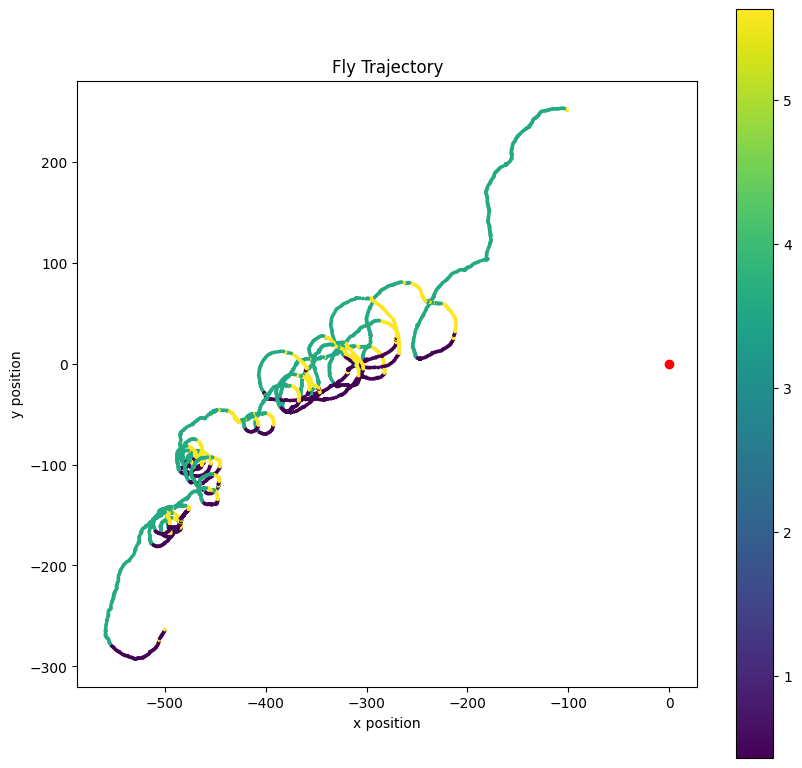

In [52]:
label = 'cluster_peak_angle'
query_idx1 = 1400
query_idx2 = 5500
x_range = max(xPos) - min(xPos)
y_range = max(yPos) - min(yPos)
aspect_ratio = y_range / x_range

# Set figure dimensions based on data range while keeping unit scale the same
fig_width = 10  # Width of figure in inches
fig_height = fig_width * aspect_ratio  # Height is scaled according to the aspect ratio of the data

plt.figure(figsize=(fig_width, fig_height))

if label in behav_df.columns:
    # If the label exists, color the scatter plot based on the label values
    plt.scatter(xPos[query_idx1:query_idx2], yPos[query_idx1:query_idx2], c=behav_df[label][query_idx1:query_idx2], s=3)
    plt.colorbar()  # Optionally, add a color bar to indicate the mapping of color to label values
else:
    # If the label does not exist, plot a normal scatter plot without coloring
    plt.scatter(xPos, yPos, s=3)
    label = "nothing"
plt.scatter(0, 0, color='red')  # Mark the origin

# Enforce equal aspect ratio so that one unit in x is the same as one unit in y
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Fly Trajectory')

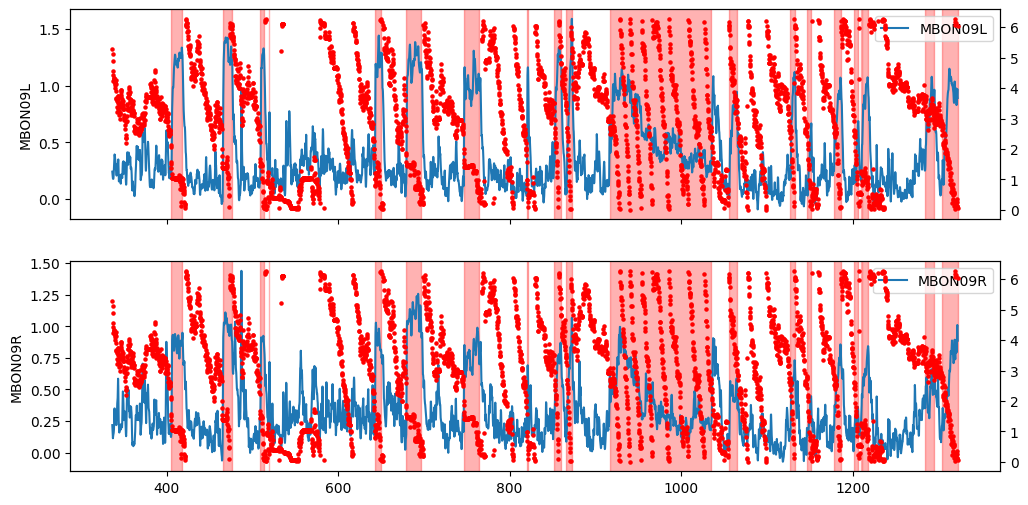

In [53]:
neural_columns = len(neural_df.columns.drop('time'))
behav_columns = len(['fwV', 'yawV', 'sideV', 'heading'])
total_plots = neural_columns #+ behav_columns

# Create a figure with subplots
fig, axs = plt.subplots(total_plots, 1, figsize=(12, 3 * total_plots), sharex=True)

# Plot each column from neural_df as a subplot
for i, column in enumerate(neural_df.columns.drop('time')):
    axs[i].plot(neural_df['time'][query_idx1:query_idx2], neural_df[column][query_idx1:query_idx2], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')
    axs2 = axs[i].twinx()
    axs2.scatter(behav_df['time'][query_idx1:query_idx2], behav_df['heading'][query_idx1:query_idx2],s=5,label='heading',color = 'red')

# Plot specified columns from behav_df as subplots
'''behav_columns = ['fwV', 'yawV', 'sideV', 'heading']
for j, column in enumerate(behav_columns, start=neural_columns):
    if column in behav_df.columns:
        axs[j].plot(behav_df['time'], behav_df[column], label=column, linestyle='--')
        axs[j].set_ylabel(column)
        axs[j].legend(loc='upper right')'''

# Check if 'odor' column exists and shade where odor > 5
if 'odor' in behav_df.columns:
    odor_mask = behav_df['odor'][query_idx1:query_idx2] > 5
    # Apply shading to all subplots
    for ax in axs:
        ax.fill_between(behav_df['time'][query_idx1:query_idx2], ax.get_ylim()[0], ax.get_ylim()[1], where=odor_mask, color='red', alpha=0.3, transform=ax.get_xaxis_transform())


#### Plot segment based activity heading tuning (based on manual index)

In [54]:
unique_mode_headings = behav_df['cluster_peak_angle'].unique()

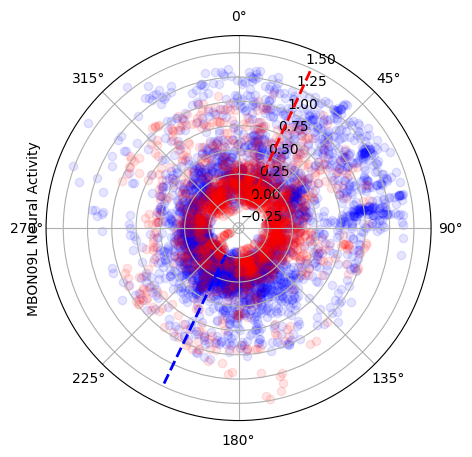

In [55]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})  # Set the projection to polar
# Convert 'heading' to radians, assuming it's in degrees
#ax.scatter(behav_df['heading'], neural_df['MBON09L'], c=behav_df['odor'], cmap='viridis')
ax.scatter(behav_df['heading'][1400:5500], neural_df['MBON09L'][1400:5500], color = 'blue', alpha=0.1)
ax.scatter(behav_df['heading'][5500:8000], neural_df['MBON09L'][5500:8000], color = 'red', alpha=0.1)
ax.set_theta_zero_location('N')  # Optional: Set 0 degrees (north) at the top
ax.set_theta_direction(-1)  # Optional: Set the angular direction clockwise

# Optional: Label the colorbar for clarity
#cbar = plt.colorbar(ax.collections[0], ax=ax)
#cbar.set_label('Odor')

# Set labels for neural data
ax.set_ylabel("MBON09L Neural Activity")
# Add a radial line at a specific radian (for example, at pi/4 radians)
mode_hd = unique_mode_headings[1]
ax.plot([mode_hd, mode_hd], [0, 1.5], color='red', linewidth=2, linestyle='--')
mode_hd2 = unique_mode_headings[2]
ax.plot([mode_hd2, mode_hd2], [0, 1.5], color='blue', linewidth=2, linestyle='--')
plt.show()


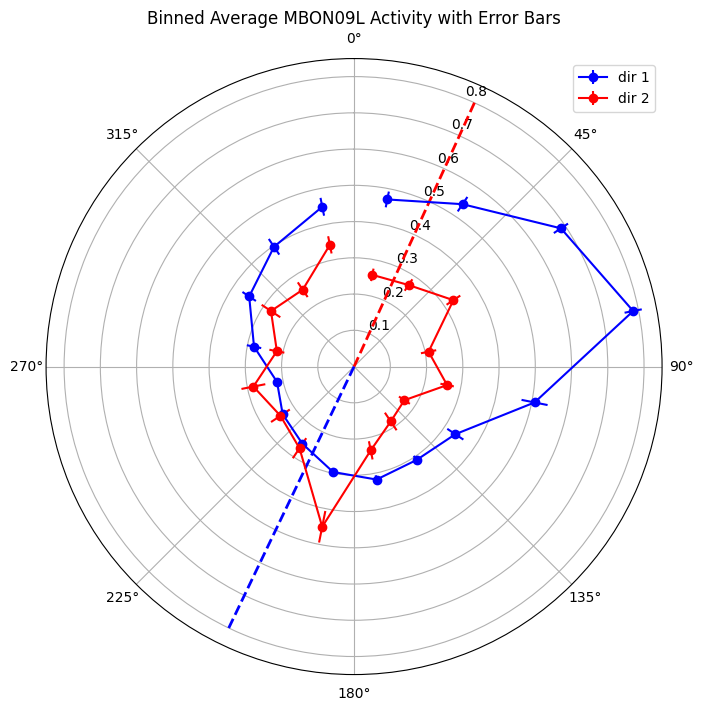

In [56]:
def binned_stats(headings, values, bins):
    """
    Calculate binned averages and standard errors.
    
    Parameters:
    - headings: array of angular data (in radians).
    - values: corresponding values (e.g., MBON09L) to be averaged.
    - bins: number of bins or a list of bin edges for angular data.
    
    Returns:
    - bin_centers: array of bin centers (in radians).
    - bin_means: array of mean values for each bin.
    - bin_errors: array of standard errors for each bin.
    """
    # Bin the heading data
    binned, bin_edges = pd.cut(headings, bins=bins, labels=False, retbins=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate mean and standard error for MBON09L activity in each bin
    bin_means = []
    bin_errors = []
    for i in range(len(bin_edges) - 1):
        bin_values = values[binned == i]
        bin_means.append(np.mean(bin_values))
        bin_errors.append(np.std(bin_values) / np.sqrt(len(bin_values)))  # Standard error

    return bin_centers, np.array(bin_means), np.array(bin_errors)

# Convert heading to radians and filter data
#behav_df['heading_rad'] = np.deg2rad(behav_df['heading'])
#with_odor = behav_df['odor'] >5
#without_odor = behav_df['odor'] <=5

# Define bins for the circular data (e.g., 12 bins)
bins = np.linspace(0, 2 * np.pi, 17)

# Calculate binned statistics for both conditions
centers_with, means_with, errors_with = binned_stats(behav_df['heading'][1400:5500], neural_df['MBON09L'][1400:5500], bins)
centers_without, means_without, errors_without = binned_stats(behav_df['heading'][5500:8000], neural_df['MBON09L'][5500:8000], bins)

# Plotting on polar coordinates
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.errorbar(centers_with, means_with, yerr=errors_with, fmt='o-', label='dir 1', color='blue')
ax.errorbar(centers_without, means_without, yerr=errors_without, fmt='o-', label='dir 2', color='red')

# Additional plot settings
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Binned Average MBON09L Activity with Error Bars')
ax.legend()

# Add a radial line at a specific radian (for example, at pi/4 radians)
mode_hd = unique_mode_headings[1]
ax.plot([mode_hd, mode_hd], [0, 0.8], color='red', linewidth=2, linestyle='--')
mode_hd2 = unique_mode_headings[2]
ax.plot([mode_hd2, mode_hd2], [0, 0.8], color='blue', linewidth=2, linestyle='--')

plt.show()


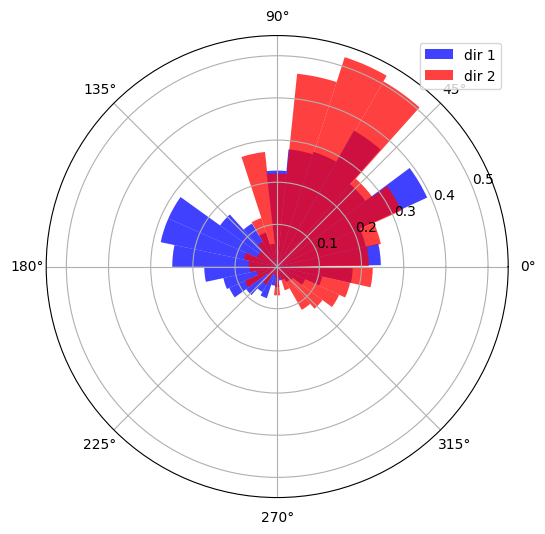

In [66]:

# Define a short window (e.g., 100 samples before and after each transition)
window_size = 20

# Identify transitions (either on = odor > 5 or off = odor <= 5)
odor_on = np.array(behav_df['odor'] > 5)

# Find the indices where any transition occurs (on-to-off or off-to-on)
transitions = np.where(odor_on[:-1] != odor_on[1:])[0]  # Detect any change

# Extract windows around transitions
windows_1 = [behav_df['heading'][max(1400, idx-window_size):min(5500, idx+window_size)] for idx in transitions]
windows_2 = [behav_df['heading'][max(5500, idx-window_size):min(8000, idx+window_size)] for idx in transitions]

# Concatenate the data from all windows
heading_transition_1 = pd.concat(windows_1)
heading_transition_2 = pd.concat(windows_2)
# Plotting the circular histogram of 'heading' for all transitions
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Circular histogram for all odor transitions
ax.hist(heading_transition_1, bins=30, density=True, color='blue', alpha=0.75, label="dir 1")
ax.hist(heading_transition_2, bins=30, density=True, color='red', alpha=0.75, label="dir 2")
ax.legend()
#ax.set_title('Circular Histogram: Odor Transitions')

plt.show()

In [61]:
odor_on[1:]

1       False
2       False
3       False
4       False
5       False
        ...  
7480    False
7481    False
7482    False
7483    False
7484    False
Name: odor, Length: 7484, dtype: bool

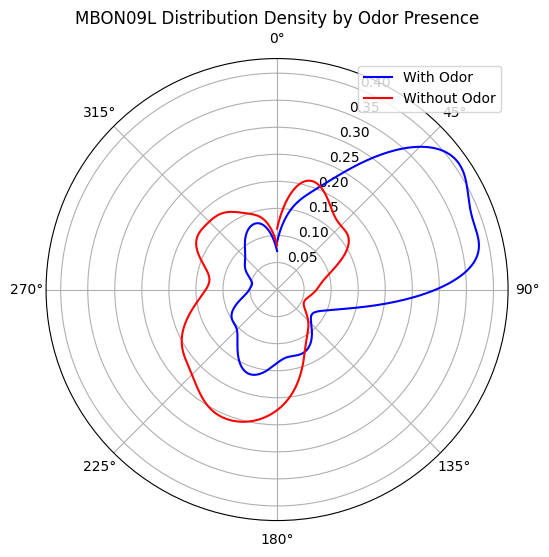

In [37]:
def circular_kde(data, headings, bandwidth=0.1):
    """
    Perform KDE on circular data (MBON09L values) with respect to the heading (in radians).
    
    Parameters:
    - data: The data values (e.g., MBON09L) for which we want to compute density.
    - headings: Circular variable (heading in radians) as the angular support.
    - bandwidth: Bandwidth for KDE.
    
    Returns:
    - kde_values: KDE estimated values.
    - theta_grid: Corresponding angular grid points (in radians).
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)  # 0 to 2*pi for the circular support
    kde = gaussian_kde(headings, weights=data, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

with_odor = behav_df['odor'] > 5
without_odor = behav_df['odor'] <= 5

# Perform circular KDE for MBON09L distribution for both conditions
kde_with_odor, theta_grid = circular_kde(neural_df['MBON09L'][with_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][with_odor & (neural_df['MBON09L'] >= 0)])
kde_without_odor, _ = circular_kde(neural_df['MBON09L'][without_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][without_odor & (neural_df['MBON09L'] >= 0)])

# Plot the KDE results on the polar coordinate system
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': 'polar'})

# Plot KDE curve for with odor
ax.plot(theta_grid, kde_with_odor, label='With Odor', color='blue')

# Plot KDE curve for without odor
ax.plot(theta_grid, kde_without_odor, label='Without Odor', color='red')

# Add titles, legend, and labels
ax.set_title("MBON09L Distribution Density by Odor Presence")
ax.set_theta_zero_location('N')  # Set 0 degrees (north) at the top
ax.set_theta_direction(-1)       # Set the angular direction clockwise

# Add legend
ax.legend(loc="upper right")

plt.show()


In [35]:
np.where(neural_df['MBON09L'][with_odor]<0)

(array([1433, 1434, 1703, 1704, 1705, 1706], dtype=int64),)

### EPG processing 

In [5]:
epg_df = neural_df.filter(like='EPG')
epg_df

,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,EPG_9,...,EPG_20,EPG_21,EPG_22,EPG_23,EPG_24,EPG_25,EPG_26,EPG_27,EPG_28,EPG_29
0,2.723054,0.892353,1.214028,1.743374,2.166797,2.234061,3.058426,2.674723,2.845853,3.090423,...,1.778661,2.459945,2.474280,1.743127,1.903536,1.877679,1.714433,1.692436,1.355308,0.981021
1,2.864456,1.103269,1.143212,1.687360,2.074136,2.198340,2.757989,2.533699,2.644873,2.942089,...,1.762801,2.308727,2.410312,1.729007,2.047879,2.164652,2.136542,2.246190,1.914916,1.590011
2,3.738657,1.476766,1.308932,1.620242,1.944892,1.964879,2.320715,2.172650,2.277311,2.658761,...,1.508232,1.955571,2.123074,1.511344,2.087945,2.317293,2.457225,2.679639,2.448921,2.207648
3,4.636425,1.782339,1.477424,1.501613,1.705614,1.653203,1.928812,1.738895,1.871738,2.263781,...,1.190439,1.606212,1.756443,1.225380,2.056184,2.322880,2.607774,2.879525,2.760156,2.509236
4,5.248745,1.893037,1.570783,1.434932,1.479327,1.433266,1.633765,1.391593,1.505390,1.903914,...,0.993123,1.353303,1.454187,1.032984,1.954573,2.272118,2.633817,2.989960,2.861271,2.608892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,2.729314,2.416504,1.905878,0.930155,1.025140,0.267064,0.170871,0.304852,0.255301,0.627908,...,0.278155,0.177689,0.436523,0.415495,1.040792,1.464250,2.470433,2.659594,3.026334,3.505047
2053,2.701487,2.401290,1.726724,0.879139,0.960849,0.369732,0.223090,0.288241,0.201353,0.550387,...,0.228247,0.212573,0.398730,0.419965,0.991494,1.491411,2.483958,2.652767,2.948268,3.443189
2054,2.074075,2.155816,1.477726,0.893341,0.900961,0.448354,0.260100,0.230421,0.219046,0.573498,...,0.218835,0.232854,0.484072,0.461322,0.991760,1.543880,2.520692,2.705019,2.880502,3.289761
2055,1.723742,1.951129,1.303298,0.988706,0.984354,0.465009,0.250617,0.194844,0.260288,0.614825,...,0.259136,0.219845,0.604700,0.505460,1.009610,1.518933,2.422403,2.714442,2.869919,3.184348


<Axes: >

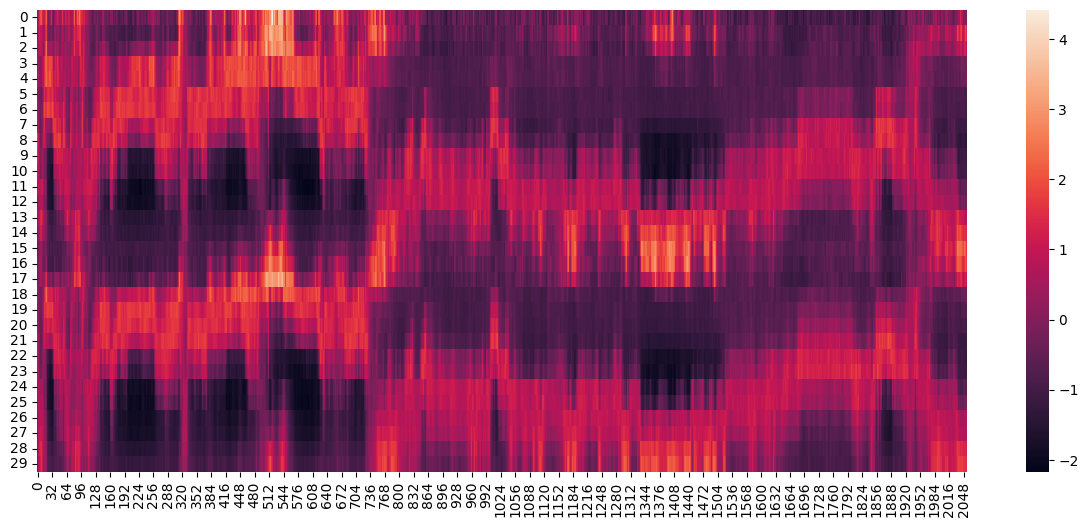

In [6]:
scaler = StandardScaler()
roi_mtx_ori =  epg_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [7]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_epg(np.transpose(roi_mtx))

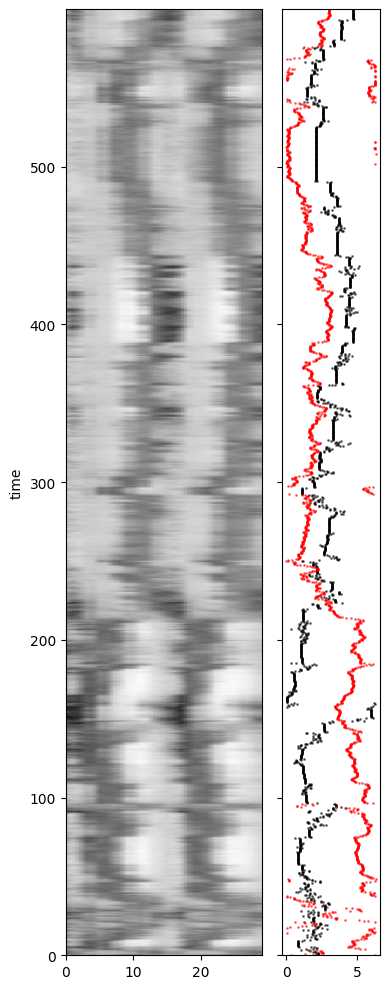

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()



In [21]:
# calculate offset
phase_dif_epg = np.angle(np.exp(1j*behav_df.heading[ind1:ind2])/np.exp(1j*(pva_phase[ind1:ind2]+np.pi))) 
phase_dif_epg

array([1.7138969 , 1.94166096, 1.7783599 , ..., 1.86761494, 1.86154615,
       1.88850513])

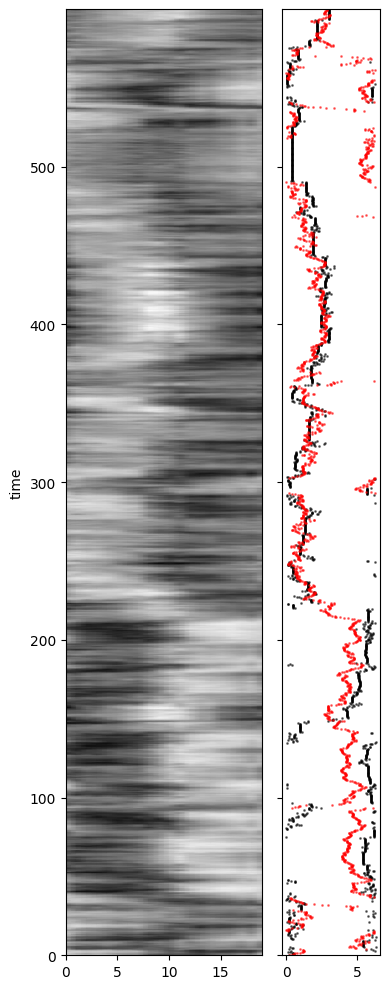

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
hd_zerooff = behav_df.heading-phase_dif_epg[0]
hd_zerooff[hd_zerooff<0] += 2*np.pi
ax2.scatter(hd_zerooff, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('epg.pdf', format='pdf', bbox_inches='tight')


Text(0, 0.5, 'heading')

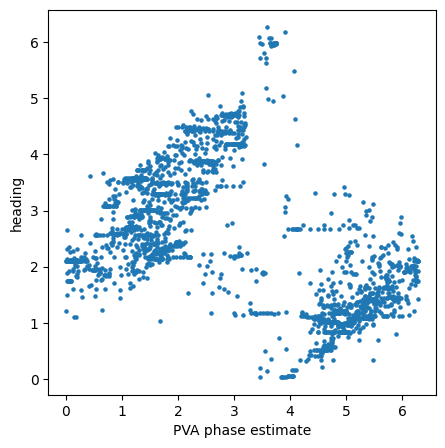

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pva_phase+np.pi, behav_df.heading, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

In [11]:

# Columns to smooth
cols_to_smooth = ['fwV','sideV','yawV']
sigma = 8
def smooth_columns(df, cols_to_smooth,sigma):
    # Create a new DataFrame with smoothed columns
    smoothed_df = pd.DataFrame()

    for col in df.columns:
        if col in cols_to_smooth:
            smoothed_data = gaussian_filter1d(df[col].values, sigma=sigma, mode='nearest')
            smoothed_df[col] = smoothed_data
        else:
            smoothed_df[col] = df[col]
    return smoothed_df

smoothed_df = smooth_columns(behav_df, cols_to_smooth,sigma)

In [12]:
smoothed_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628


In [13]:
def calculate_translational_velocity_df(df):
    """
    Calculate translational velocities and directions for multiple time points provided in a DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns 'fwV' for forward velocity (mm/s) 
                               and 'sideV' for side velocity (rad/s).
        radius (float): Radius of the ball in mm.
        heading_direction_rad (float): Instantaneous heading direction of the animal in radians (assumed constant for simplicity).

    Returns:
        pandas.DataFrame: DataFrame with additional columns 'translational_velocity_mm_s' and 'translational_direction_rad'.
    """
    # Convert side velocity from rad/s to mm/s
    #df['side_velocity_mm'] = df['sideV'] * radius

    # Calculate the magnitude of the translational velocity
    df['translational_velocity_mm_s'] = np.sqrt(df['sideV']**2 + df['fwV']**2)

    # Calculate the direction of the translational velocity
    df['translational_direction_rad'] = (df['heading'] + np.arctan2(df['sideV'], df['fwV'])) % (2*np.pi)


    return df

radius = 4.5 
result_df = calculate_translational_velocity_df(smoothed_df)
result_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,translational_velocity_mm_s,translational_direction_rad
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000,2.167289,1.708252
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125,2.491626,2.044969
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403,2.827320,2.013503
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565,3.166852,2.010010
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001,3.501691,2.011389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741,0.423842,5.801482
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813,0.456705,5.836382
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944,0.478213,5.855043
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628,0.490618,5.846461


In [14]:
hdeltab_df = neural_df.filter(like='hDeltaB')
hdeltab_df

,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,hDeltaB_10,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16,hDeltaB_17,hDeltaB_18,hDeltaB_19
0,-0.193967,-0.000457,0.073373,0.019750,0.177525,0.426502,0.683414,0.780667,0.944247,1.071649,0.917875,0.786426,0.894922,1.093610,0.843931,0.730944,0.588569,0.487070,0.504135,0.010910
1,-0.116115,0.059882,0.099784,0.043648,0.168415,0.392602,0.599247,0.678869,0.904270,0.980953,0.896351,0.754305,0.864112,1.139721,0.946442,0.766402,0.670169,0.577942,0.567977,0.090014
2,-0.030915,0.105457,0.150837,0.090545,0.181895,0.361443,0.485518,0.530761,0.842716,0.871166,0.844065,0.692316,0.844093,1.152871,1.004232,0.780436,0.759679,0.640261,0.609428,0.160382
3,0.018073,0.113260,0.210224,0.118139,0.203891,0.350504,0.422369,0.423375,0.751085,0.746232,0.790395,0.628125,0.839876,1.127049,1.019851,0.769844,0.817656,0.648546,0.649909,0.196785
4,0.018680,0.136706,0.251679,0.129589,0.265536,0.385921,0.406132,0.398921,0.657362,0.672613,0.750189,0.607239,0.815054,1.112682,1.016412,0.791079,0.845272,0.668738,0.705568,0.211975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,0.725296,0.559247,0.465383,0.465341,0.371303,0.290641,0.151348,0.145858,0.216029,0.138736,0.044434,0.019219,0.129350,0.344191,0.601073,0.639127,0.735293,0.937902,0.830761,1.025948
2053,0.754518,0.641993,0.499176,0.443159,0.405628,0.296574,0.181517,0.110212,0.193165,0.177968,0.057779,0.030147,0.093549,0.342221,0.590682,0.618950,0.708239,0.926642,0.801019,1.074110
2054,0.745142,0.678675,0.520800,0.448398,0.436572,0.294794,0.163118,0.100149,0.178068,0.160501,0.078860,0.037575,0.117841,0.342180,0.610917,0.593001,0.674209,0.886596,0.796549,1.153398
2055,0.754913,0.655963,0.506834,0.480879,0.418295,0.333264,0.129951,0.092716,0.158295,0.138725,0.086364,0.048558,0.171463,0.321312,0.619844,0.596116,0.632169,0.834929,0.764140,1.193808


<Axes: >

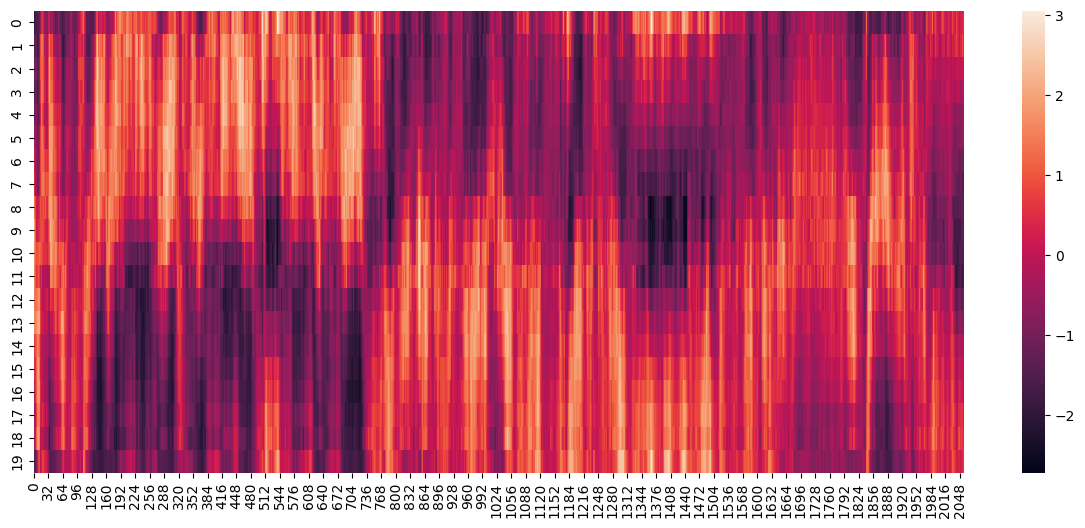

In [15]:
scaler = StandardScaler()
roi_mtx_ori =  hdeltab_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [16]:
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,3.637634,0.162491,1.751337,0.068677,0.083554,0.116011
1,0.291806,3.637634,0.173620,1.613633,0.069444,0.078162,0.108998
2,0.583611,3.637634,0.140976,1.446100,0.073902,0.074983,0.105208
3,0.875417,3.968328,0.077666,1.301645,0.083940,0.077088,0.108779
4,1.167222,3.968328,0.058063,1.197554,0.098021,0.083132,0.117748
...,...,...,...,...,...,...,...
2052,598.784922,5.952491,-0.498071,1.023527,0.067553,0.047858,0.066187
2053,599.076727,0.000000,-0.482666,1.043530,0.063070,0.045518,0.062895
2054,599.368533,0.000000,-0.475032,1.054903,0.056112,0.040930,0.056543
2055,599.660338,0.000000,-0.487071,1.035013,0.049882,0.035700,0.049321


In [17]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_hdeltab(np.transpose(roi_mtx))

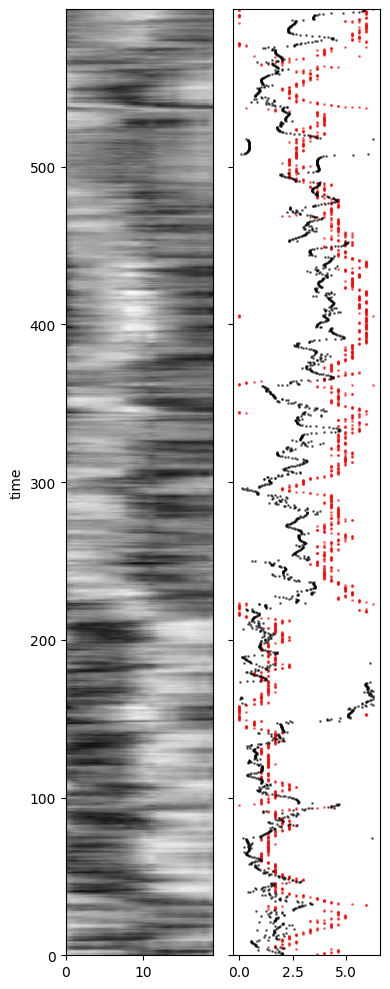

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(param_df.phase, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()

In [28]:
# calculate offset
phase_dif_hdeltab = np.angle(np.exp(1j*param_df.phase[ind1:ind2])/np.exp(1j*result_df.translational_direction_rad)) 
phase_dif_hdeltab

array([1.92938122, 1.59266462, 1.62413038, ..., 0.42814227, 0.43672413,
       0.44168583])

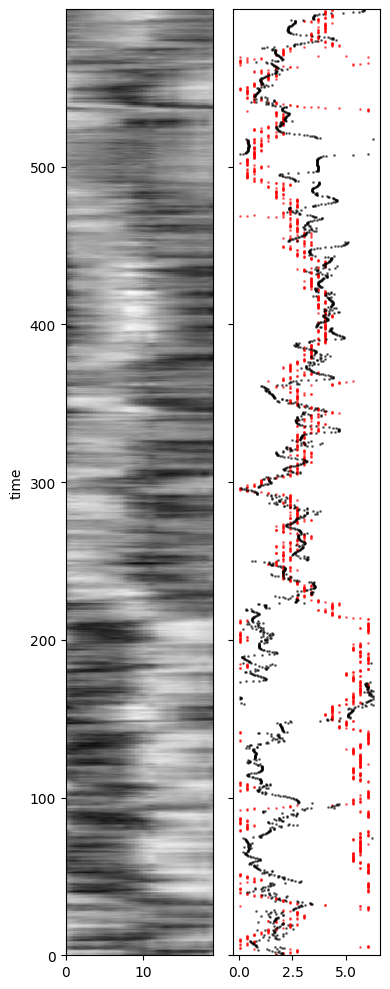

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
phase_zerooff = param_df.phase-phase_dif_hdeltab[0]
phase_zerooff[phase_zerooff<0] += 2*np.pi
ax2.scatter(phase_zerooff, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('hdeltab.pdf', format='pdf', bbox_inches='tight')

Text(0, 0.5, 'phase')

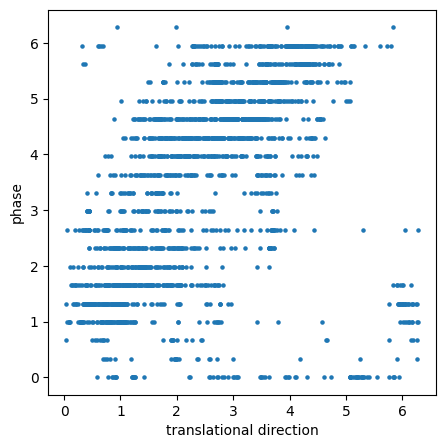

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_direction_rad, param_df.phase, marker = 'o',s=5)
#ax.scatter(behav_df.heading, pva_phase+np.pi, marker = 'o',color = 'red',s=5)
ax.set_xlabel('translational direction')
ax.set_ylabel('phase')

Text(0, 0.5, 'bump amplitude')

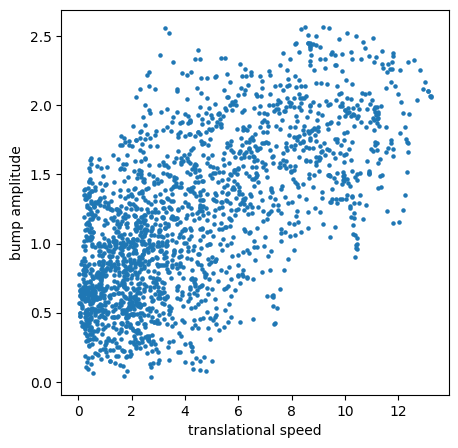

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_velocity_mm_s, param_df.amplitude, marker = 'o',s=5)
ax.set_xlabel('translational speed')
ax.set_ylabel('bump amplitude')